<a href="https://colab.research.google.com/github/AayushJaiswal01/deep_learning/blob/main/AudioClassificationCapuchinBirds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!ls /content/drive/MyDrive/data_set

'Forest Recordings'   Parsed_Capuchinbird_Clips   Parsed_Not_Capuchinbird_Clips


In [42]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten


In [43]:
import tensorflow_io as tfio

In [44]:
CAPUCHIN_FILE = os.path.join("/content/drive/MyDrive/data_set", 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/data_set', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [45]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [46]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

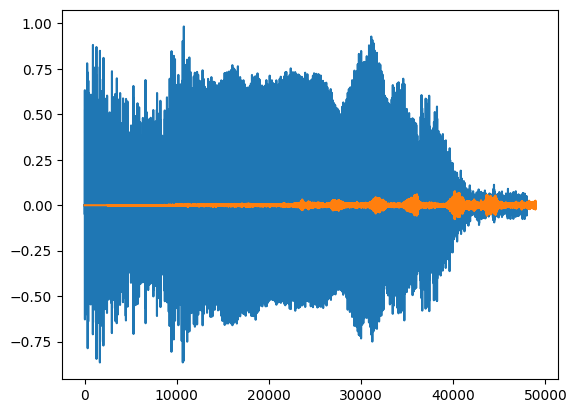

In [47]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [48]:
capuchin = os.path.join('/content/drive/MyDrive/data_set', 'Parsed_Capuchinbird_Clips')
not_capuchin= os.path.join('/content/drive/MyDrive/data_set', 'Parsed_Not_Capuchinbird_Clips')

In [49]:
capuchin_set = tf.data.Dataset.list_files(capuchin+'/*.wav')
not_capuchin_set= tf.data.Dataset.list_files(NEG+'/*.wav')

In [50]:
capuchin_set1 = tf.data.Dataset.zip((capuchin_set, tf.data.Dataset.from_tensor_slices(tf.ones(len(capuchin_set)))))
not_capuchin_set1 = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(not_capuchin_set)))))
data = capuchin_set1.concatenate(not_capuchin_set1)

In [51]:
lengths = []
for file in os.listdir(os.path.join('/content/drive/MyDrive/data_set', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('/content/drive/MyDrive/data_set', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [52]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [53]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

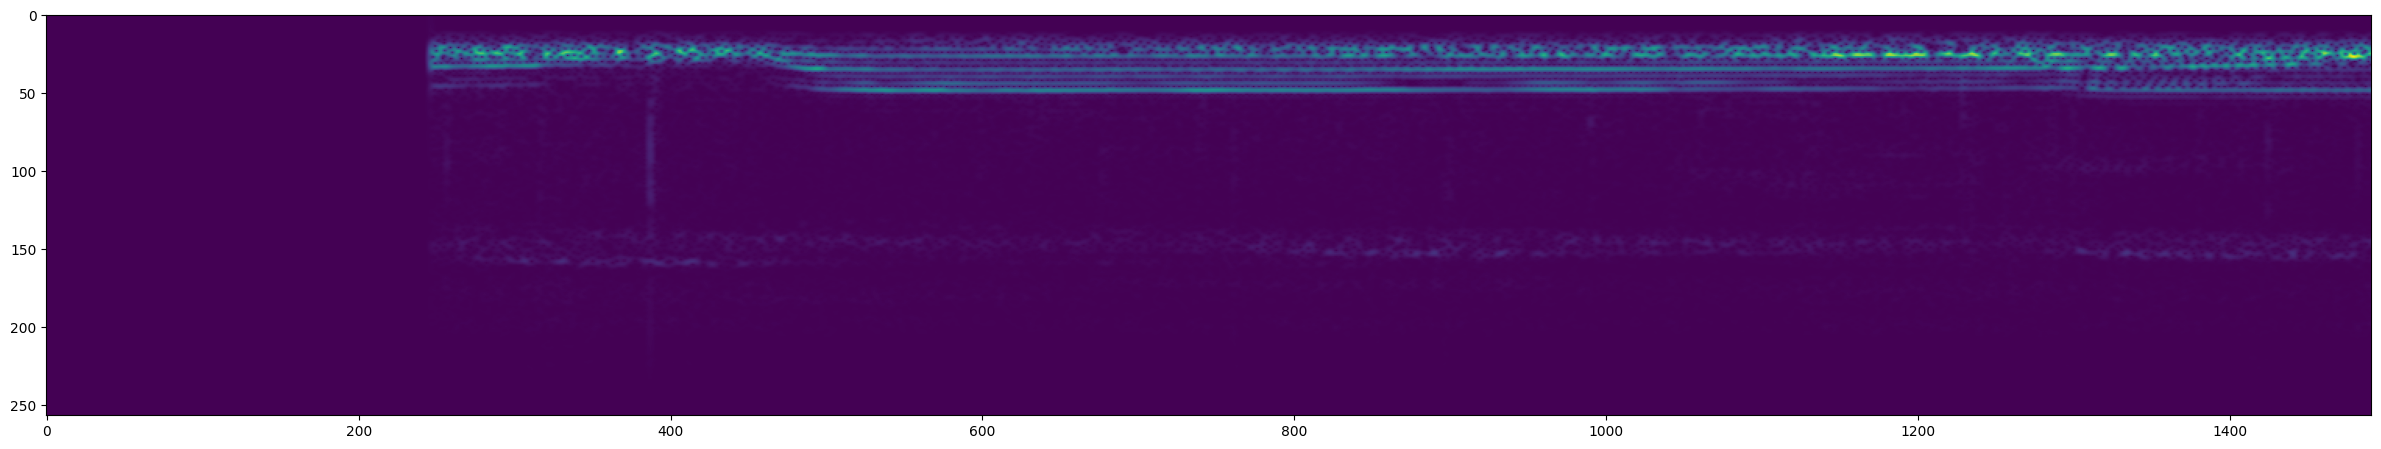

In [54]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()


In [55]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [56]:
train = data.take(36)
test = data.skip(36).take(15)

In [57]:
samples, labels = train.as_numpy_iterator().next()

In [58]:
samples.shape


(16, 1491, 257, 1)

In [59]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [60]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [61]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 261s 7s/step - loss: 2.1693 - recall_1: 0.8528 - precision_1: 0.8081 - val_loss: 0.1413 - val_recall_1: 0.8421 - val_precision_1: 0.9796
Epoch 2/4
36/36 [==============================] - 261s 7s/step - loss: 0.1022 - recall_1: 0.9317 - precision_1: 0.9804 - val_loss: 0.0314 - val_recall_1: 0.9706 - val_precision_1: 1.0000
Epoch 3/4
36/36 [==============================] - 245s 7s/step - loss: 0.0257 - recall_1: 0.9795 - precision_1: 0.9931 - val_loss: 0.0193 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 4/4
36/36 [==============================] - 253s 7s/step - loss: 0.0154 - recall_1: 0.9814 - precision_1: 1.0000 - val_loss: 0.0105 - val_recall_1: 0.9839 - val_precision_1: 1.0000


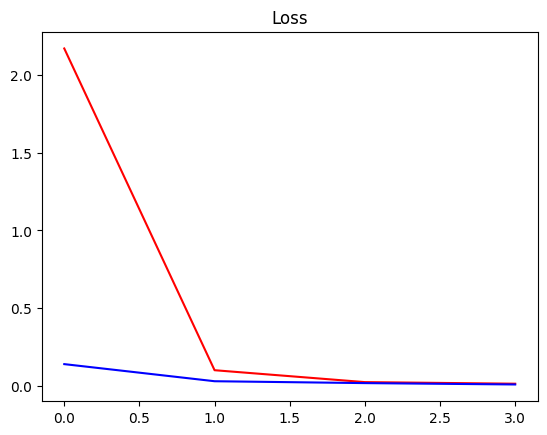

In [62]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [63]:
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [64]:
from itertools import groupby

In [65]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [66]:
results = {}
for file in os.listdir(os.path.join('/content/drive/MyDrive/data_set', 'Forest Recordings')):
    FILEPATH = os.path.join('/content/drive/MyDrive/data_set','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 [==============================] - 6s 6s/step


In [67]:
results['recording_02.mp3']


array([[2.0217011e-19],
       [1.0487109e-15],
       [5.3934198e-17],
       [2.7421305e-16],
       [1.2130635e-16],
       [1.4444398e-15],
       [6.1537593e-21],
       [1.4971639e-14],
       [4.3835337e-16],
       [5.4643514e-16],
       [1.0318224e-22],
       [1.1443253e-15],
       [3.4273700e-21],
       [3.8127121e-15],
       [2.4336794e-15],
       [8.4553812e-24],
       [2.1466912e-22],
       [3.1571239e-16],
       [1.3768139e-20],
       [1.2820836e-13],
       [6.5858154e-15],
       [9.4349188e-18],
       [7.1799534e-18],
       [5.1382619e-15],
       [7.2508560e-18],
       [2.0437268e-15],
       [4.3276614e-14],
       [3.8668653e-14],
       [5.5273582e-21],
       [2.7703585e-14],
       [1.8382863e-14],
       [4.0981720e-16],
       [1.2167074e-14],
       [2.9105797e-14],
       [3.4558134e-17],
       [6.9872989e-18],
       [5.7292573e-16],
       [8.4941167e-15],
       [5.8342688e-21],
       [4.8276432e-18],
       [2.8489521e-15],
       [3.063033

In [68]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [69]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()


In [70]:
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 16,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_14.mp3': 0,
 'recording_13.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_19.mp3': 0,
 'recording_18.mp3': 4,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_25.mp3': 10,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_24.mp3': 0,
 'recording_29.mp3': 0,
 'recording_28.mp3': 18,
 'recording_31.mp3': 1,
 'recording_30.mp3': 3,
 'recording_32.mp3': 2,
 'recording_35.mp3': 0,
 'recording_34.mp3': 4,
 'recording_33.mp3': 0,
 'recording_38.mp3': 1,
 'recording_37.mp3': 3,
 'recording_36.mp3': 0,
 'recording_40.mp3': 1,
 'recording_42.mp3': 0,
 'recording_4